   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.2 MB/s eta 0:00:00
        datetime_str         RA       DEC     delta         r
0  2025-Jul-01 00:00  271.97741 -18.69705  3.508359  4.516094
1  2025-Jul-02 00:00  271.46306 -18.68546  3.477723  4.482740
2  2025-Jul-03 00:00  270.94050 -18.67260  3.447611  4.449403
3  2025-Jul-04 00:00  270.40980 -18.65843  3.418026  4.416084
4  2025-Jul-05 00:00  269.87105 -18.64286  3.388972  4.382784


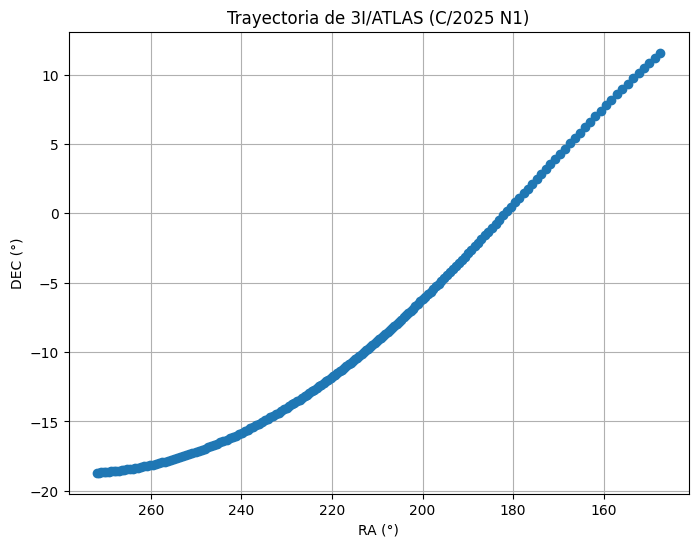

In [ ]:
!pip install astroquery

from astroquery.jplhorizons import Horizons
import pandas as pd
import matplotlib.pyplot as plt

obj = Horizons(id='C/2025 N1', location='500@399',
               epochs={'start':'2025-07-01','stop':'2025-12-31','step':'1d'})
tab = obj.ephemerides()
df = tab.to_pandas()

print(df[['datetime_str','RA','DEC','delta','r']].head())

# Graficar RA vs DEC
plt.figure(figsize=(8,6))
plt.plot(df['RA'], df['DEC'], marker='o', linestyle='-')
plt.gca().invert_xaxis()
plt.xlabel('RA (°)')
plt.ylabel('DEC (°)')
plt.title('Trayectoria de 3I/ATLAS (C/2025 N1)')
plt.grid(True)
plt.show()

# Exportar CSV
df.to_csv('3I_ATLAS_ephem.csv', index=False)


# Automatizado

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00


/tmp/ipython-input-257733867.py:11: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  hoy = datetime.utcnow()


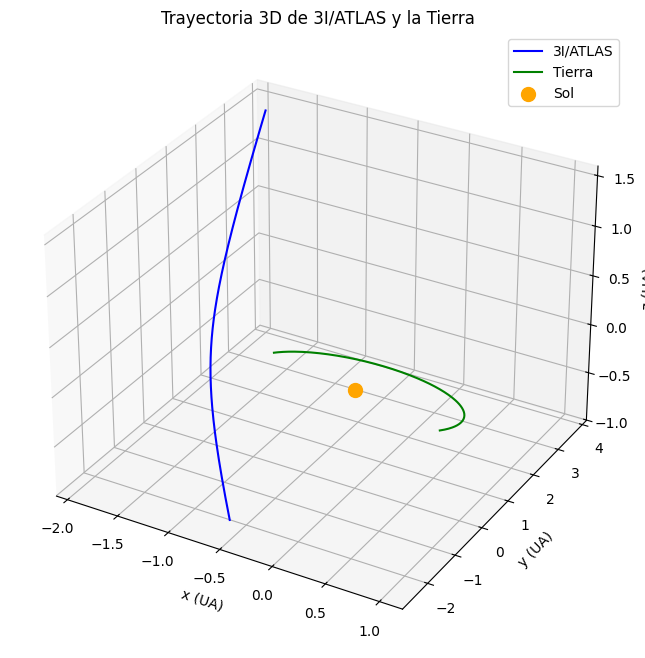

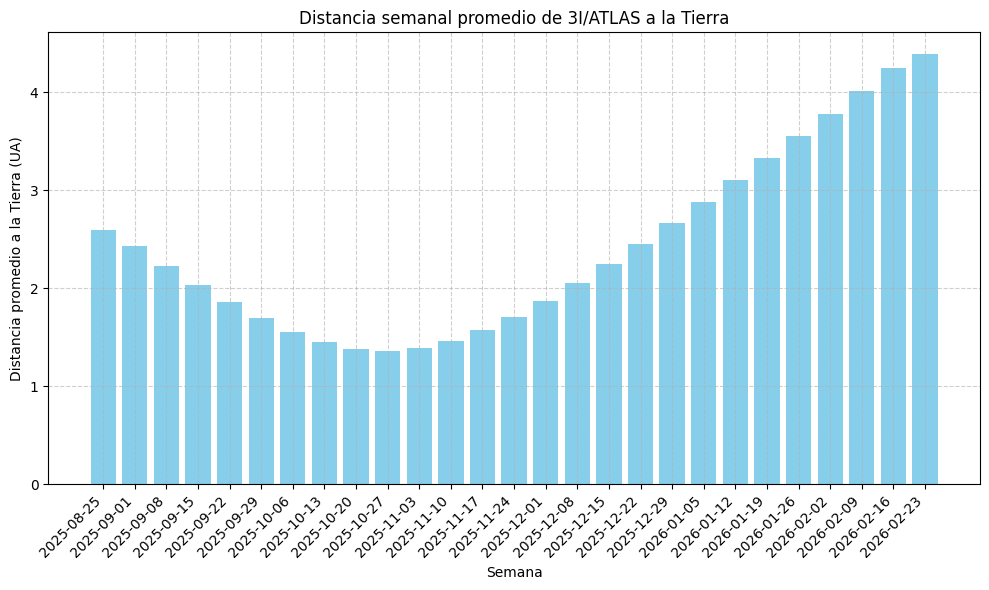

In [ ]:
!pip install astroquery

from astroquery.jplhorizons import Horizons
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D

# ----- Fechas dinámicas -----
hoy = datetime.utcnow()
fin = hoy + timedelta(days=180)
start_str = hoy.strftime('%Y-%m-%d')
stop_str = fin.strftime('%Y-%m-%d')

# ----- Obtener efemérides del cometa -----
cometa = Horizons(id='C/2025 N1', location='500@0',  # 500@0 = Sol
                  epochs={'start': start_str, 'stop': stop_str, 'step': '1d'})
tab_cometa = cometa.ephemerides()
df_cometa = tab_cometa.to_pandas()

# ----- Convertir coordenadas espaciales -----
df_cometa['RA_rad'] = np.deg2rad(df_cometa['RA'])
df_cometa['DEC_rad'] = np.deg2rad(df_cometa['DEC'])
df_cometa['x'] = df_cometa['r'] * np.cos(df_cometa['DEC_rad']) * np.cos(df_cometa['RA_rad'])
df_cometa['y'] = df_cometa['r'] * np.cos(df_cometa['DEC_rad']) * np.sin(df_cometa['RA_rad'])
df_cometa['z'] = df_cometa['r'] * np.sin(df_cometa['DEC_rad'])

# ----- Obtener efemérides de la Tierra -----
tierra = Horizons(id='399', location='500@0',
                  epochs={'start': start_str, 'stop': stop_str, 'step': '1d'})
tab_tierra = tierra.vectors()
df_tierra = tab_tierra.to_pandas()
df_tierra[['x', 'y', 'z']] = df_tierra[['x', 'y', 'z']].astype(float)

# ----- Gráfico 3D de trayectorias -----
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(df_cometa['x'], df_cometa['y'], df_cometa['z'], label='3I/ATLAS', color='blue')
ax.plot(df_tierra['x'], df_tierra['y'], df_tierra['z'], label='Tierra', color='green')
ax.scatter(0, 0, 0, color='orange', s=100, label='Sol')

ax.set_xlabel('x (UA)')
ax.set_ylabel('y (UA)')
ax.set_zlabel('z (UA)')
ax.set_title('Trayectoria 3D de 3I/ATLAS y la Tierra')
ax.legend()
plt.show()

print('\n')
# ----- Histograma de distancia promedio semanal -----
df_cometa['datetime'] = pd.to_datetime(df_cometa['datetime_str'])
df_cometa['semana'] = df_cometa['datetime'].dt.to_period('W').apply(lambda r: r.start_time)
distancia_semanal = df_cometa.groupby('semana')['delta'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.bar(distancia_semanal['semana'].dt.strftime('%Y-%m-%d'), distancia_semanal['delta'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Semana')
plt.ylabel('Distancia promedio a la Tierra (UA)')
plt.title('Distancia semanal promedio de 3I/ATLAS a la Tierra')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
